In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# tensorflow 
# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Dropout, Conv1D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

# Common imports
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from numpy import concatenate
from pandas import concat
from pandas import DataFrame
from datetime import date
from math import sqrt
import holidays
sns.set()
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = "Verdana"

In [ ]:
# # Enabling and testing the GPU with tensorflow
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# %cd /content/drive/My Drive/L9/

## Preprocessing

In [2]:
df = pd.read_csv('data/clean/df9.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429120 entries, 0 to 429119
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   DateTime       429120 non-null  object 
 1   Volume         429120 non-null  float64
 2   Speed          429120 non-null  float64
 3   Occupancy      429120 non-null  float64
 4   Incident_Type  2738 non-null    object 
dtypes: float64(3), object(2)
memory usage: 16.4+ MB


In [ ]:
    # Take into account daily and weekly periodicity
#     timestamp_s = df.index.map(pd.Timestamp.timestamp)
#     day = 24*60*60 # seconds
#     week = (7)*day
#     df['Sin_day'] = np.sin(timestamp_s * (2 * np.pi / day))
#     df['Cos_day'] = np.cos(timestamp_s * (2 * np.pi / day))
#     df['Sin_week'] = np.sin(timestamp_s * (2 * np.pi / week))
#     df['Cos_week'] = np.cos(timestamp_s * (2 * np.pi / week))

In [6]:
import calendar
print(calendar.calendar(2018))

                                  2018

      January                   February                   March
Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7                1  2  3  4                1  2  3  4
 8  9 10 11 12 13 14       5  6  7  8  9 10 11       5  6  7  8  9 10 11
15 16 17 18 19 20 21      12 13 14 15 16 17 18      12 13 14 15 16 17 18
22 23 24 25 26 27 28      19 20 21 22 23 24 25      19 20 21 22 23 24 25
29 30 31                  26 27 28                  26 27 28 29 30 31

       April                      May                       June
Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su
                   1          1  2  3  4  5  6                   1  2  3
 2  3  4  5  6  7  8       7  8  9 10 11 12 13       4  5  6  7  8  9 10
 9 10 11 12 13 14 15      14 15 16 17 18 19 20      11 12 13 14 15 16 17
16 17 18 19 20 21 22      21 22 23 24 25 26 27      18 19 20 21 22 23 24
23 24 25 26 27 28 29      28 

In [ ]:
def preprocessing(df):
    df['Incident'] = df['Incident_Type'].notnull().astype(int)
    df['Density'] = df['Occupancy']*4000/700
    df = df[['DateTime', 'Volume', 'Speed', 'Density', 'Incident']]
    # Set DateTime as index and sort
    df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
    df = df.set_index('DateTime')
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
    
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    num_features = df.shape[1]

        
    df = df.astype('float32')

## Baseline

- Incident: 2018-07-18 between 12:51:00 - 14:24:00 (1.33 hours)
- Investigation period: 018-07-18 between 12:30:00 - 14:30:00 (2 hours)
- Prediction using the average traffic variables of the same weekday


## MLP

In [18]:
def preprocessing(df):
    df['Incident'] = df['Incident_Type'].notnull().astype(int)
    df['Density'] = df['Occupancy']*4000/700
    df = df[['DateTime', 'Volume', 'Speed', 'Density', 'Incident']]
    # Set DateTime as index and sort
    df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
    df = df.set_index('DateTime')
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
        
    df = df.astype('float32')
        
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    # specify the number of lag minutes
    n_mins = 30
    n_features = 4
    # frame as supervised learning
    reframed = series_to_supervised(df.values, n_mins, 1)
    reframed.drop(reframed.columns[[-1]],axis=1, inplace=True)
    
    # Split data into training, test, and validation sets
    n_train_mins = 1440 * 198 # 198 days
    n_train_max = 1440 * 264 # 264 days
    train = reframed.iloc[:n_train_mins,:]
    # test = reframed.iloc[n_train_mins:,:]
    test = reframed.iloc[n_train_mins:n_train_max,:]
    
    # Normalise data
    sc = MinMaxScaler(feature_range = (0, 1))
    train_sc = sc.fit_transform(train.values)
    test_sc = sc.transform(test.values)
  
    # Split into input and outputs
    n_obs = n_mins * n_features
    n_out = 3
    x_train, y_train = train_sc[:,:n_obs], train_sc[:,-n_out:]
    x_test, y_test = test_sc[:,:n_obs], test_sc[:,-n_out:]

    # Reshape
    x_train = x_train.reshape((x_train.shape[0], n_mins, n_features))
    x_test = x_test.reshape((x_test.shape[0], n_mins, n_features))
    
    return sc, df, x_train, y_train, x_test, y_test
    
sc, df2, x_train, y_train, x_test, y_test = preprocessing(df)
print('======= df.info() before reframing =====')
print(df2.info())
print('========================================')
print("df.shape: {}".format(df2.shape))
print("x_train.shape: {}".format(x_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("x_test.shape: {}".format(x_test.shape))
print("y_test.shape: {}".format(y_test.shape))
print('========================================')

======= df.info() before reframing =====
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429120 entries, 2018-01-01 00:00:00 to 2018-10-25 23:59:00
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Volume    429120 non-null  float32
 1   Speed     429120 non-null  float32
 2   Density   429120 non-null  float32
 3   Incident  429120 non-null  float32
dtypes: float32(4)
memory usage: 9.8 MB
None
df.shape: (429120, 4)
x_train.shape: (285120, 30, 4)
y_train.shape: (285120, 3)
x_test.shape: (95040, 30, 4)
y_test.shape: (95040, 3)


In [85]:
df2.index.map(pd.Timestamp.timestamp)

Float64Index([1514764800.0, 1514764860.0, 1514764920.0, 1514764980.0,
              1514765040.0, 1514765100.0, 1514765160.0, 1514765220.0,
              1514765280.0, 1514765340.0,
              ...
              1540511400.0, 1540511460.0, 1540511520.0, 1540511580.0,
              1540511640.0, 1540511700.0, 1540511760.0, 1540511820.0,
              1540511880.0, 1540511940.0],
             dtype='float64', name='DateTime', length=429120)

In [9]:
def build_MLP(lr):
    # build sequential api model
    model = Sequential()
    # flatten lag observations into feature vectors
    model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
    # add 2 hidden layers
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    # output layer
    model.add(Dense(3))
    optimizer = keras.optimizers.Adam(lr=lr)
    # compile model
    model.compile(loss='mse', optimizer=optimizer)
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 32,603
Trainable params: 32,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8910/8910 [==============================] - 4s 463us/step - loss: 0.0030 - val_loss: 0.0204
Epoch 2/100
8

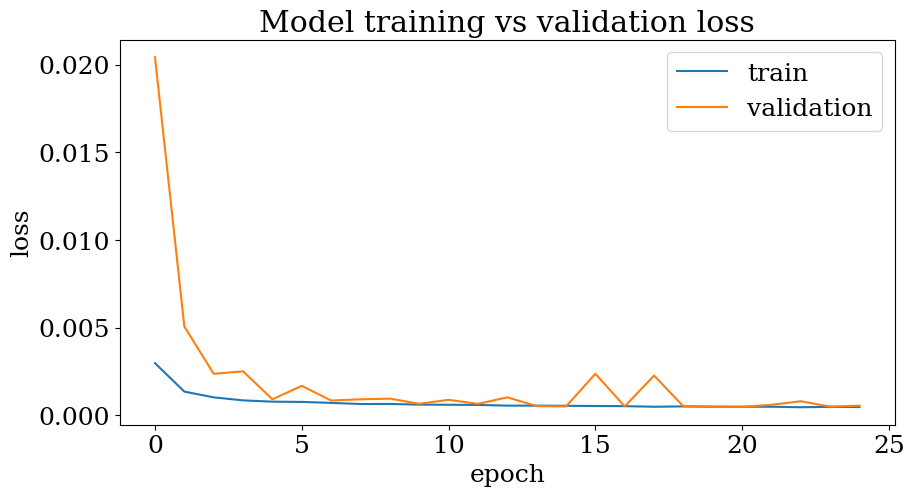

In [19]:
from numpy.random import seed
seed(1914)
tf.random.set_seed(1914)
# seed(42)
# tf.random.set_seed(42)

K.clear_session()

batch_size=32
epochs=100

model1 = build_MLP(0.001)
model1.summary()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=20, verbose=0,
    baseline=None, restore_best_weights=True)
start_time1 = timeit.default_timer()
history1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    verbose=1, shuffle=False, callbacks=[early_stop])
elapsed1 = timeit.default_timer() - start_time1

# summarize history for loss
plt.rcParams["font.size"] = 18
plt.figure(figsize = (10,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model training vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
# MLP2.h5
print('Training time: {} sec or {} min'.format(elapsed1, elapsed1/60))

Training time: 105.5617794000002 sec or 1.7593629900000034 min


In [22]:
model1.save("model/MLP2.h5")
print("Saved model to disk")

Saved model to disk


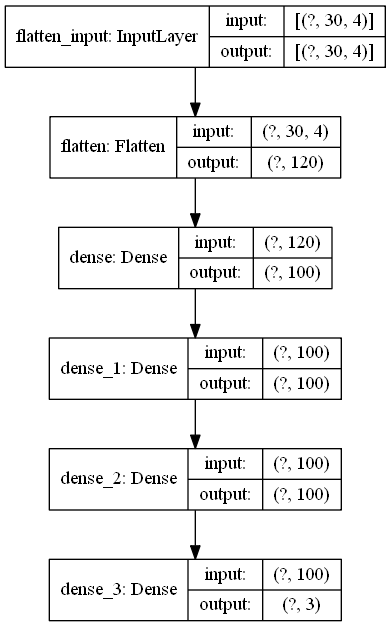

In [23]:
import pydotplus
keras.utils.plot_model(model1, "fig/L9/MLP2.png", show_shapes=True)

In [55]:
# MLP.h5
print('Training time: {} sec or {} min'.format(elapsed1, elapsed1/60))

Training time: 49.22297310000022 sec or 0.8203828850000037 min


In [56]:
model1.save("model/MLP.h5")
print("Saved model to disk")

Saved model to disk


In [4]:
model1 = load_model("model/MLP.h5")

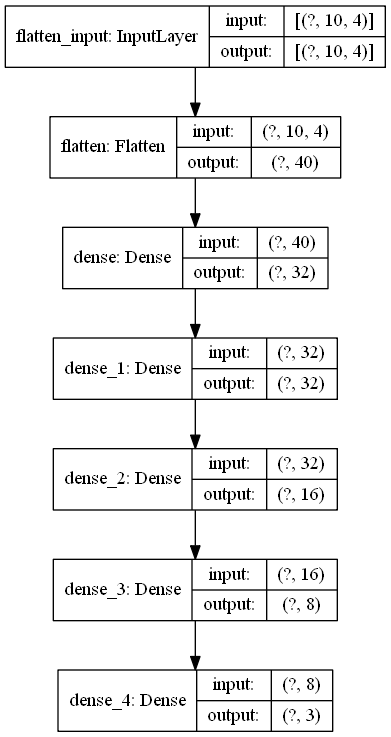

In [5]:
import pydotplus
keras.utils.plot_model(model1, "fig/L9/MLP.png", show_shapes=True)

In [12]:
n_mins=30
n_features=4

# Test: make a prediction
y_hat = model1.predict(x_test)
 
# reshape
test_X = x_test.reshape((x_test.shape[0], n_mins*n_features))

# Test
inv_yhat = concatenate((y_hat, test_X), axis=1)
inv_yhat = sc.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:3] # first 3 columns contain predictions

test_y = y_test.reshape((len(y_test),3)) #changed 1 to 2
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = sc.inverse_transform(inv_y)
inv_y = inv_y[:,:3] # first 3 columns contain actual values
 
rmse_v = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for volume
rmse_s = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for speed
rmse_d = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for density

In [13]:
# Train: make a prediction
yt_hat = model1.predict(x_train)
 
# reshape
train_X = x_train.reshape((x_train.shape[0], n_mins*n_features))

# Train
inv_yhatt = concatenate((yt_hat, train_X), axis=1)
inv_yhatt = sc.inverse_transform(inv_yhatt)
inv_yhatt = inv_yhatt[:,:3] # first 3 columns contain predictions

train_y = y_train.reshape((len(y_train),3)) #changed 1 to 2
inv_yt = concatenate((train_y, train_X), axis=1)
inv_yt = sc.inverse_transform(inv_yt)
inv_yt = inv_yt[:,:3] # first 3 columns contain actual values

rmset_v = sqrt(mean_squared_error(inv_yt[:,0], inv_yhatt[:,0])) #RMSE for volume
rmset_s = sqrt(mean_squared_error(inv_yt[:,1], inv_yhatt[:,1])) #RMSE for speed
rmset_d = sqrt(mean_squared_error(inv_yt[:,2], inv_yhatt[:,2])) #RMSE for density

In [14]:
print('======= Train RMSE ======')
print('Flow Rate: %.4f' % rmset_v)
print('Speed: %.4f' % rmset_s)
print('Density: %.4f' % rmset_d)
print('=========================')
print('======= Test RMSE ======')
print('Flow Rate: %.4f' % rmse_v)
print('Speed: %.4f' % rmse_s)
print('Density: %.4f' % rmse_d)
print('=========================')

======= Train RMSE ======
Flow Rate: 3.6101
Speed: 4.9959
Density: 6.6397
======= Test RMSE ======
Flow Rate: 3.8249
Speed: 5.4271
Density: 5.9485


In [28]:
mean_squared_error(inv_y[:,0], inv_yhat[:,0])

14.629881

In [25]:
mean_squared_error(inv_y[:1440,1], inv_yhat[:1440,1])

43.482845

In [26]:
mean_squared_error(inv_y[:1440,2], inv_yhat[:1440,2])

86.53341

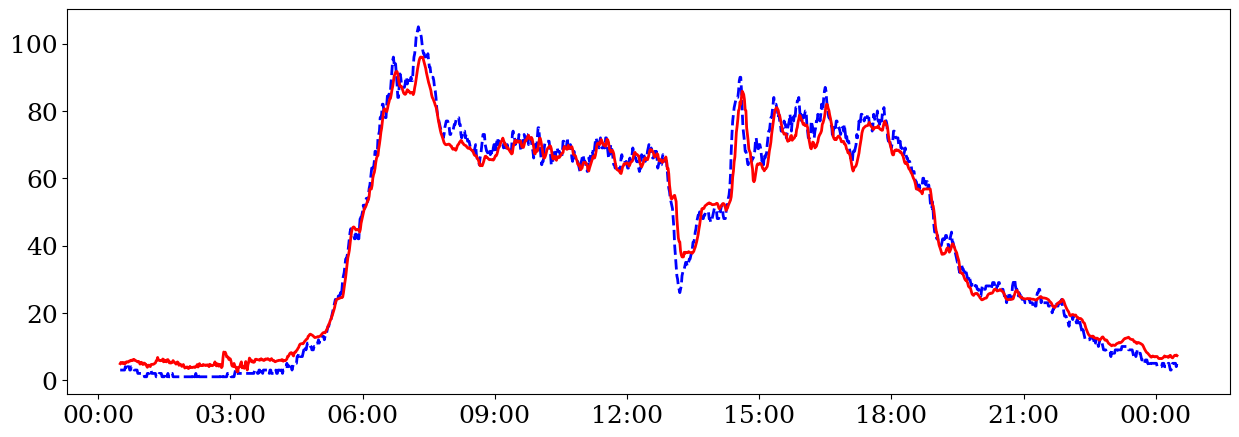

In [20]:
# Volume
dls = pd.date_range(start='2018-07-18 00:30:00', end='2018-07-19 00:29:00', freq='1min')
figure, ax = plt.subplots(figsize=(15,5))
plt.plot(dls, inv_y[:1440,0], color = 'blue', label = 'Actual', linestyle = '--', linewidth=2, zorder=1)
plt.plot(dls, inv_yhat[:1440,0], color = 'red', label = 'Predicted', linewidth=2, zorder=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

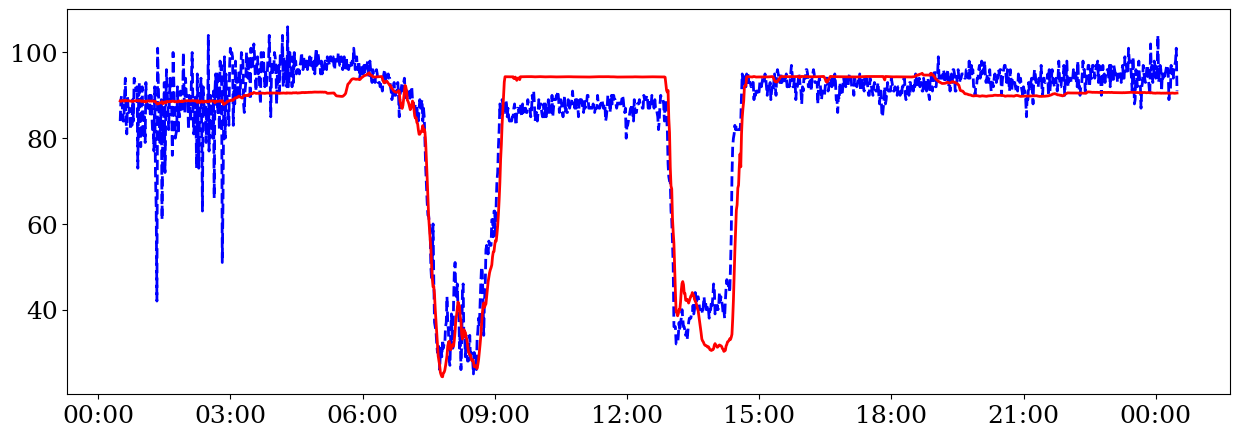

In [16]:
figure, ax = plt.subplots(figsize=(15,5))
plt.plot(dls, inv_y[:1440,1], color = 'blue', label = 'Actual', linestyle = '--', linewidth=2, zorder=1)
plt.plot(dls, inv_yhat[:1440,1], color = 'red', label = 'Predicted', linewidth=2, zorder=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

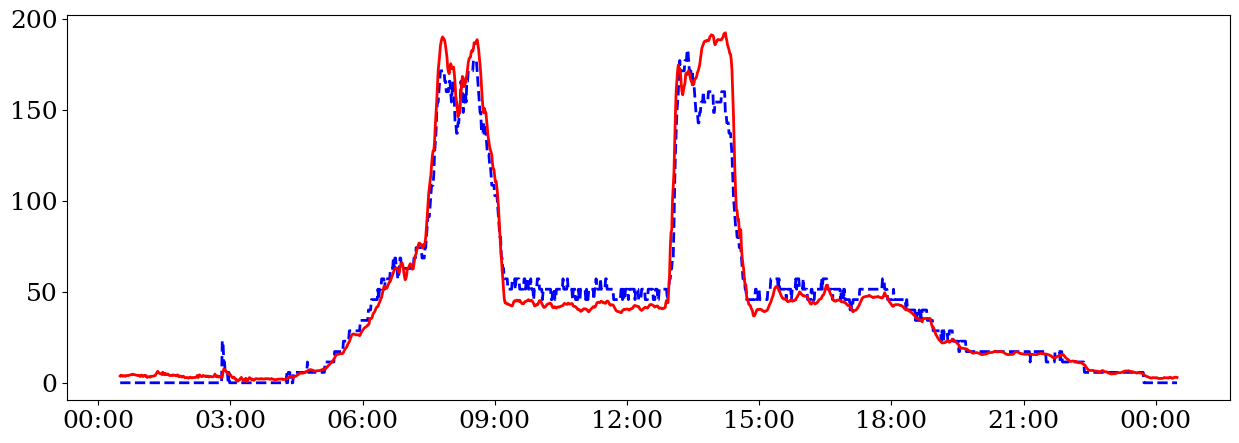

In [17]:
figure, ax = plt.subplots(figsize=(15,5))
plt.plot(dls, inv_y[:1440,2], color = 'blue', label = 'Actual', linestyle = '--', linewidth=2, zorder=1)
plt.plot(dls, inv_yhat[:1440,2], color = 'red', label = 'Predicted', linewidth=2, zorder=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()